Цель этой лабораторной работы - продемонстрировать работу алгоритмы поиска соответсвующих точек на снимках.

In [2]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
# from google.colab import files

## Load images

In [4]:
#Base image
base_image = cv2.imread('Ground/DSC_0174.JPG')
base_image = np.stack((base_image[:,:,2], base_image[:,:,1], base_image[:,:,0]), axis = -1)

In [5]:
# Image to warp
warp_image = cv2.imread('Ground/DSC_0175.JPG')
warp_image = np.stack((warp_image[:,:,2], warp_image[:,:,1], warp_image[:,:,0]), axis = -1)

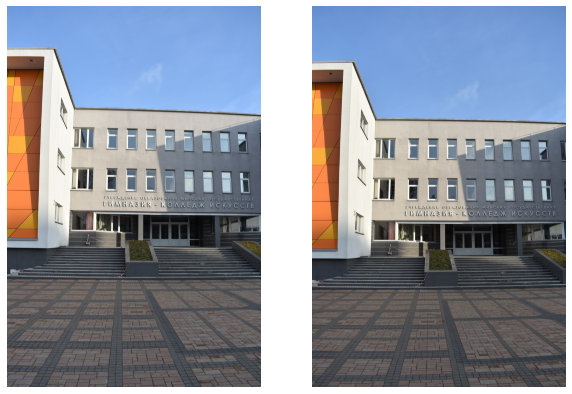

In [9]:
#To view images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(base_image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(warp_image)
plt.axis('off')
plt.show()

## Find matching points

In [10]:
#Convert to greyscale image
base_image_grey = cv2.cvtColor(base_image,cv2.COLOR_BGR2GRAY)
warp_image_grey = cv2.cvtColor(warp_image,cv2.COLOR_BGR2GRAY)

In [11]:
#Parameters to find points
n_points = 5000 #number of points
confidence = 75 #confidence for points matching
show_key_points = False
height, width = base_image_grey.shape

In [13]:
#We are using ORB detector
#https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html
orb_detector = cv2.ORB_create(n_points)

In [15]:
kp1, d1 = orb_detector.detectAndCompute(base_image_grey, None)
kp2, d2 = orb_detector.detectAndCompute(warp_image_grey, None)

In [16]:
#kp - tie point
#d - point description, its coordinates, brirghtness, environments
kp1[0], d1[0]

(<KeyPoint 0x7ffac9f6fed0>,
 array([  2, 152,  22, 153, 203, 228, 176,  71, 174,  25,  64,  49, 172,
        150,  96,  72, 231,  59, 251, 144,  18,   9, 146, 241,  13,  48,
         26,  75, 144,   0, 165, 159], dtype=uint8))

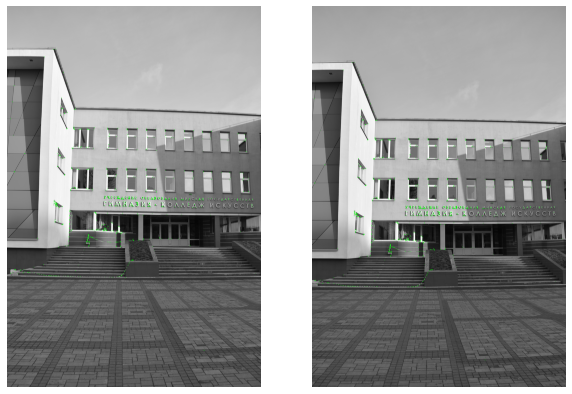

In [19]:
#Show points on images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
key_pointe_image_1 = cv2.drawKeypoints(base_image_grey, kp1, None, color=(0,255,0), flags=0)
plt.imshow(key_pointe_image_1)
plt.axis('off')
plt.subplot(1, 2, 2)
key_pointe_image_2 = cv2.drawKeypoints(warp_image_grey, kp2, None, color=(0,255,0), flags=0)
plt.imshow(key_pointe_image_2)
plt.axis('off')
plt.show()

In [26]:
# Match points on images usin Hamming distanse В качестве параметра будет использовано Расстояние Хэмминга
# https://en.wikipedia.org/wiki/Hamming_distance
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Match points description
matches = list(matcher.match(d1, d2))

# Sort matches by Hamming dist
matches.sort(key = lambda x: x.distance)

# Select points with confidence above threshold
matches = matches[:int(len(matches)*confidence)] 
no_of_matches = len(matches) 

p1 = np.zeros((no_of_matches, 2)) 
p2 = np.zeros((no_of_matches, 2)) 

for i in range(len(matches)):
    p1[i, :] = kp1[matches[i].queryIdx].pt
    p2[i, :] = kp2[matches[i].trainIdx].pt 

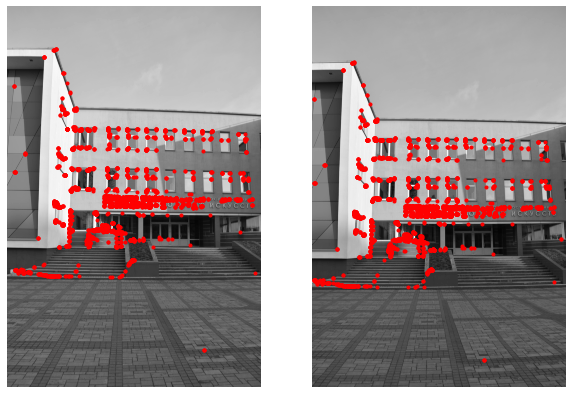

In [29]:
#check selected points
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.scatter(p1[:,0], p1[:,1], marker='.', c = 'red')
plt.imshow(base_image_grey, cmap = 'gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(p2[:,0], p2[:,1], marker='.', c = 'red')
plt.imshow(warp_image_grey, cmap = 'gray')
plt.axis('off')
plt.show()

## Transform image

In [30]:
# Compute transformation matrix
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
# Transform image 
transformed_img = cv2.warpPerspective(warp_image_grey, homography, (width, height))

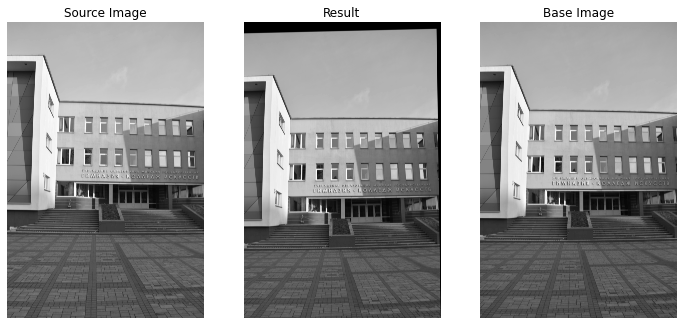

In [34]:
#Show result
plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.title('Source Image')
plt.imshow(base_image_grey, cmap = 'gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Result')
plt.imshow(transformed_img, cmap = 'gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Base Image')
plt.imshow(warp_image_grey, cmap = 'gray')
plt.axis('off')
plt.show()

# **Try to apply to other images**

In [ ]:
#Funcion to transform images. Draws key points
def transform_image(base_image, warp_image, n_points = 2000, confidence = 90, show_key_points = False):
    height, width, _ = base_image.shape
    
    # Create ORB detector with n_points 
    orb_detector = cv2.ORB_create(n_points) 
    
    # Find keypoints and descriptors. the first arg is the image, second arg is the mask  (which is not reqiured in this case). 
    kp1, d1 = orb_detector.detectAndCompute(base_image, None) 
    kp2, d2 = orb_detector.detectAndCompute(warp_image, None)
            
    # Match features between the two images. We create a Brute Force matcher with  Hamming distance as measurement mode. 
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    
    # Match the two sets of descriptors. 
    matches = matcher.match(d1, d2)
    
    # Sort matches on the basis of their Hamming distance. 
    matches.sort(key = lambda x: x.distance)
    
    # Take the top conf % matches
    matches = matches[:int(len(matches)*confidence)] 
    no_of_matches = len(matches) 
    
    # Define empty matrices of shape no_of_matches * 2. 
    p1 = np.zeros((no_of_matches, 2)) 
    p2 = np.zeros((no_of_matches, 2)) 

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt 
        
    # Find the homography matrix. 
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    # Use this matrix to transform the image to the reference image. 
    transformed_img = cv2.warpPerspective(warp_image, homography, (width, height))
    return transformed_img